<a href="https://colab.research.google.com/github/linhctiu/Home-Credit-Default-Risk-VEF/blob/main/Home_Credit_Default_Risk__Modelling_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix, classification_report,f1_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import SGDClassifier
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split, GridSearchCV
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import pickle
import gc
import lightgbm as lgb
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def Evaluation_model(y_test, y_pred):
  print('Accuracy:', accuracy_score(y_test, y_pred))
  print('F1 score:', f1_score(y_test, y_pred))
  print('Recall:', recall_score(y_test, y_pred))
  print('Precision:', precision_score(y_test, y_pred))
  print('\n clasification report:\n', classification_report(y_test, y_pred))


In [3]:
X_train = pd.read_csv('/content/drive/MyDrive/VEF_ML/PROJECT/X_train_final.csv',index_col=0)
X_val = pd.read_csv('/content/drive/MyDrive/VEF_ML/PROJECT/X_val_final.csv',index_col=0)
X_test = pd.read_csv('/content/drive/MyDrive/VEF_ML/PROJECT/X_test_final.csv',index_col=0)
y_train = pd.read_csv('/content/drive/MyDrive/VEF_ML/PROJECT/y_train.csv',header=None)
y_train = y_train.values.flatten().astype(int)
y_val = pd.read_csv('/content/drive/MyDrive/VEF_ML/PROJECT/y_val.csv',header=None)
y_val = y_val.values.flatten().astype(int)
y_test = pd.read_csv('/content/drive/MyDrive/VEF_ML/PROJECT/y_test.csv',header=None)
y_test = y_test.values.flatten().astype(int)


In [4]:
!pip install parfit

In [5]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf


RANDOM FOREST

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 10.4min remaining: 10.4min


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 20.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 20.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   15.3s finished


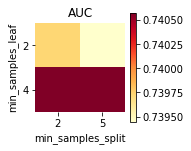

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=0,
                       warm_start=False) 0.7405718410627625


In [6]:
grid = {
    'max_depth': [10], 
    'min_samples_split': [2,5],
    'min_samples_leaf' : [2,4],
    'n_estimators' : [400],
    'n_jobs': [-1],
    'random_state': [50],
    'class_weight':['balanced']
}
paramGrid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier(), paramGrid,
                                                    X_train, y_train, X_val, y_val, # nfolds=5 [optional, instead of validation set]
                                                    metric=roc_auc_score, greater_is_better=True, 
                                                    scoreLabel='AUC')

print(best_model, best_score)

In [7]:
clf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)
best_clf = clf.fit(X_train,y_train)
feature_importance_values = clf.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance_values})
df = feature_importances.sort_values('importance', ascending = False).reset_index()
df.drop(columns='index',inplace=True)


In [8]:
columns_selected = df['feature'].iloc[0:125].values

In [9]:
#All features
y_pred = best_clf.predict(X_test)
y_pred_prob = best_clf.predict_proba(X_train)[:,1]
print('The Train AUC score is {0}'.format(roc_auc_score(y_train,y_pred_prob) ))    
y_pred_prob = best_clf.predict_proba(X_val)[:,1]
print('The Cross validated AUC score is {0}'.format(roc_auc_score(y_val,y_pred_prob) ))  
y_pred_prob = best_clf.predict_proba(X_test)[:,1]
print('The Test AUC score is {0}'.format(roc_auc_score(y_test,y_pred_prob) ))


The Train AUC score is 0.8265331341709372
The Cross validated AUC score is 0.7405718410627625
The Test AUC score is 0.7418882150511562


In [10]:
Evaluation_model(y_test, y_pred)

Accuracy: 0.7505582413770676
F1 score: 0.273244062657908
Recall: 0.5808270676691729
Precision: 0.1786422200198216

 clasification report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85     42403
           1       0.18      0.58      0.27      3724

    accuracy                           0.75     46127
   macro avg       0.57      0.67      0.56     46127
weighted avg       0.89      0.75      0.80     46127



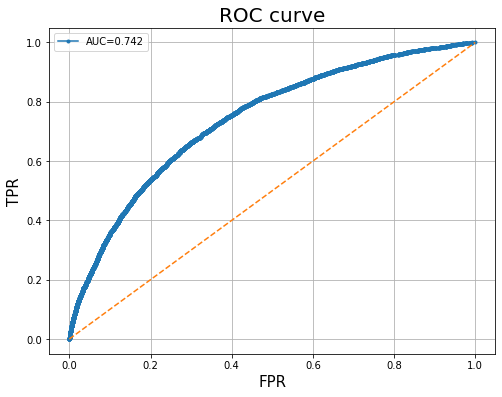

In [11]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test)[:,1])
auc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [12]:
#Feature selected
best_clf_1= clf.fit(X_train[columns_selected], y_train)
y_pred = best_clf_1.predict(X_test[columns_selected])
y_pred_prob = best_clf_1.predict_proba(X_train[columns_selected])[:,1]
print('The Train AUC score is {0}'.format(roc_auc_score(y_train,y_pred_prob) ))    
y_pred_prob = best_clf_1.predict_proba(X_val[columns_selected])[:,1]
print(' The Cross validated AUC score is {0}'.format(roc_auc_score(y_val,y_pred_prob) ))  
y_pred_prob = best_clf_1.predict_proba(X_test[columns_selected])[:,1]
print('The Test AUC score is {0}'.format(roc_auc_score(y_test,y_pred_prob) ))

The Train AUC score is 0.829672804443915
 The Cross validated AUC score is 0.7447899917808241
The Test AUC score is 0.745709807685668


In [13]:
Evaluation_model(y_test, y_pred)

Accuracy: 0.7499078630736878
F1 score: 0.2768304914744233
Recall: 0.5929108485499462
Precision: 0.18056918547595682

 clasification report:
               precision    recall  f1-score   support

           0       0.96      0.76      0.85     42403
           1       0.18      0.59      0.28      3724

    accuracy                           0.75     46127
   macro avg       0.57      0.68      0.56     46127
weighted avg       0.89      0.75      0.80     46127



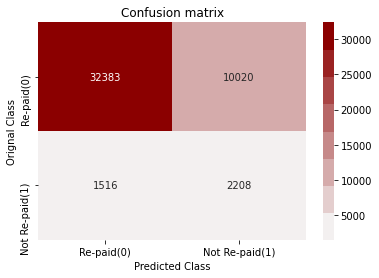

In [14]:
C = confusion_matrix(y_test, y_pred)
labels = ['Re-paid(0)','Not Re-paid(1)']
cmap=sns.light_palette("darkred", 8)
sns.heatmap(C, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Orignal Class')
plt.title('Confusion matrix')
plt.show()

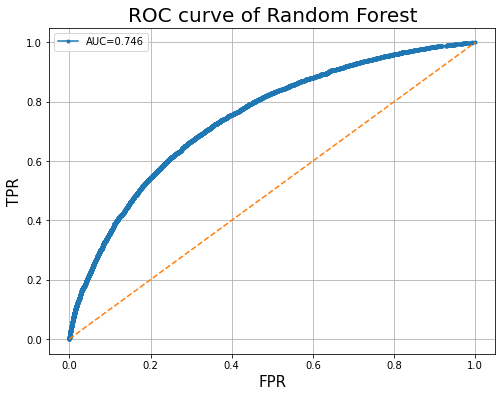

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, best_clf_1.predict_proba(X_test[columns_selected])[:,1])
auc = roc_auc_score(y_test, best_clf_1.predict_proba(X_test[columns_selected])[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve of Random Forest', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

Logistic Regression

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    1.7s finished


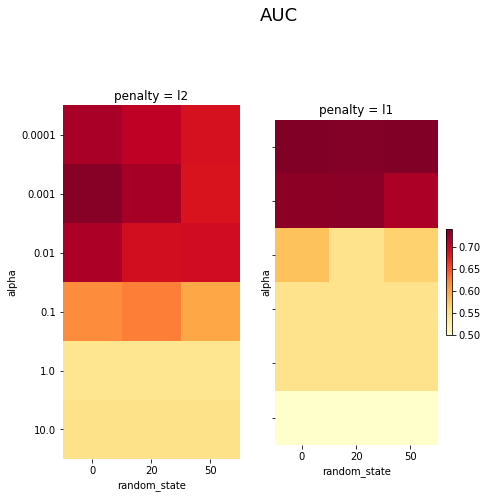

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l1', power_t=0.5,
              random_state=50, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False) 0.7412099246772688


In [16]:
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1], # learning rate
    'random_state':[0,20,50],
    'loss': ['log'], 
    'penalty': ['l2','l1'],
    'n_jobs': [-1],
}
paramGrid = ParameterGrid(grid)
best_model, best_score, all_models, all_scores = pf.bestFit(SGDClassifier, paramGrid,
                                             X_train[columns_selected], y_train, X_val[columns_selected], y_val, 
                                             metric = roc_auc_score,
                                          greater_is_better=True, scoreLabel = "AUC")
print(best_model, best_score)

In [17]:
# grid = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', verbose=True, n_jobs=-1)
# clf = SGDClassifier(alpha = 0.001, class_weight = 'balanced', penalty = 'l2', loss='log', random_state = 100,max_iter=1000)
clf = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l1', power_t=0.5,
              random_state=50, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)
best_clf= clf.fit(X_train[columns_selected], y_train)

In [18]:
y_pred = best_clf.predict(X_test[columns_selected])

In [19]:
Evaluation_model(y_test, y_pred)

Accuracy: 0.9188327877382011
F1 score: 0.04829689883070666
Recall: 0.025510204081632654
Precision: 0.4523809523809524

 clasification report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     42403
           1       0.45      0.03      0.05      3724

    accuracy                           0.92     46127
   macro avg       0.69      0.51      0.50     46127
weighted avg       0.88      0.92      0.88     46127



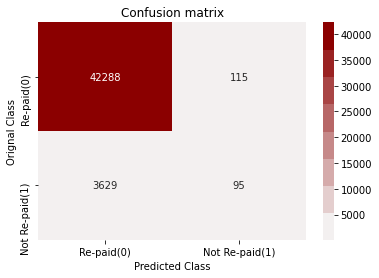

In [20]:
C = confusion_matrix(y_test, y_pred)
labels = ['Re-paid(0)','Not Re-paid(1)']
cmap=sns.light_palette("darkred", 8)
sns.heatmap(C, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Orignal Class')
plt.title('Confusion matrix')
plt.show()

In [21]:
best_alpha = 0.0001
y_pred_prob = best_clf.predict_proba(X_train[columns_selected])[:,1]
print('For best alpha {0}, The Train AUC score is {1}'.format(best_alpha, roc_auc_score(y_train,y_pred_prob) ))    
y_pred_prob = best_clf.predict_proba(X_val[columns_selected])[:,1]
print('For best alpha {0}, The Cross validated AUC score is {1}'.format(best_alpha, roc_auc_score(y_val,y_pred_prob) ))  
y_pred_prob = best_clf.predict_proba(X_test[columns_selected])[:,1]
print('For best alpha {0}, The Test AUC score is {1}'.format(best_alpha, roc_auc_score(y_test,y_pred_prob) ))

For best alpha 0.0001, The Train AUC score is 0.7437634203677703
For best alpha 0.0001, The Cross validated AUC score is 0.7412099246772688
For best alpha 0.0001, The Test AUC score is 0.7452624164539764


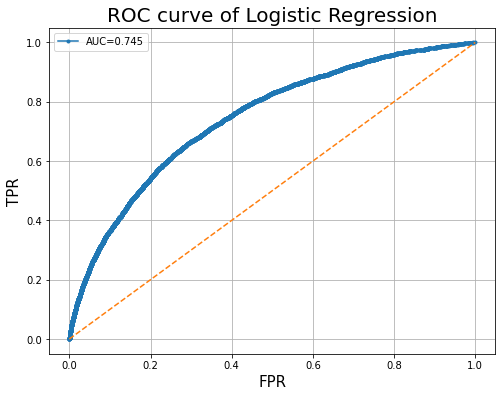

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test[columns_selected])[:,1])
auc = roc_auc_score(y_test, best_clf.predict_proba(X_test[columns_selected])[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve of Logistic Regression', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

Gradient Boosting Classifier

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 16.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 16.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


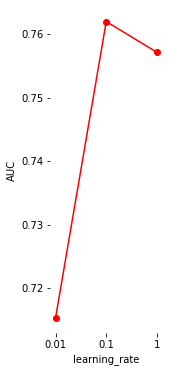

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 0.7619612987681266


In [24]:
grid = {
    'learning_rate' : [0.01,0.1,1]
}
paramGrid = ParameterGrid(grid)
best_model, best_score, all_models, all_scores = pf.bestFit(GradientBoostingClassifier(), paramGrid,
                                                    X_train[columns_selected], y_train, X_val[columns_selected], y_val,
                                                    metric=roc_auc_score, greater_is_better=True, 
                                                    scoreLabel='AUC')

print(best_model, best_score)

In [25]:
clf=GradientBoostingClassifier()
best_clf= clf.fit(X_train[columns_selected], y_train)
y_pred = best_clf.predict(X_test[columns_selected])

In [26]:
y_pred_prob = best_clf.predict_proba(X_train[columns_selected])[:,1]
print('The Train AUC score is {0}'.format(roc_auc_score(y_train,y_pred_prob) ))    
y_pred_prob = best_clf.predict_proba(X_val[columns_selected])[:,1]
print('The Cross validated AUC score is {0}'.format(roc_auc_score(y_val,y_pred_prob) ))  
y_pred_prob = best_clf.predict_proba(X_test[columns_selected])[:,1]
print('The Test AUC score is {0}'.format(roc_auc_score(y_test,y_pred_prob) ))

The Train AUC score is 0.7716844872620485
The Cross validated AUC score is 0.7619700253257621
The Test AUC score is 0.7656284477976942


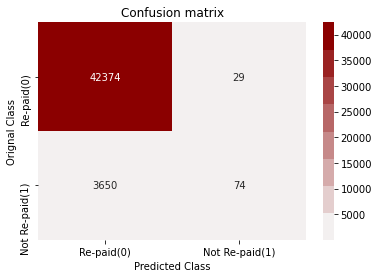

In [27]:
C = confusion_matrix(y_test, y_pred)
labels = ['Re-paid(0)','Not Re-paid(1)']
cmap=sns.light_palette("darkred", 8)
sns.heatmap(C, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Orignal Class')
plt.title('Confusion matrix')
plt.show()

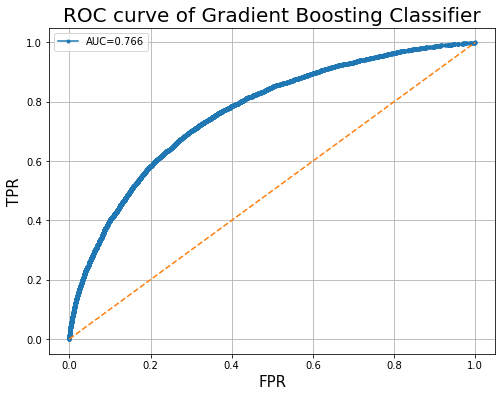

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test[columns_selected])[:,1])
auc = roc_auc_score(y_test, best_clf.predict_proba(X_test[columns_selected])[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve of Gradient Boosting Classifier', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()